In [46]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [47]:
df = pd.read_pickle("ethereum.pickle")

In [48]:
df.head()

Open    High     Low   Close       Volume    Market Cap
Date                                                                 
2020-05-02  214.23  215.85  212.88  215.33  18260876092  2.385083e+10
2020-05-01  207.90  217.63  207.78  214.22  20816320834  2.372537e+10
2020-04-30  216.91  227.53  206.44  207.60  28089191904  2.298965e+10
2020-04-29  198.47  218.45  198.12  216.97  26397548759  2.402389e+10
2020-04-28  197.27  198.79  194.85  198.42  18217507467  2.196689e+10

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1731 entries, 2020-05-02 to 2015-08-07
Data columns (total 6 columns):
Open          1731 non-null float64
High          1731 non-null float64
Low           1731 non-null float64
Close         1731 non-null float64
Volume        1731 non-null int64
Market Cap    1730 non-null float64
dtypes: float64(5), int64(1)
memory usage: 94.7 KB


In [50]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap'], dtype='object')

In [51]:
cols = ['Open', 'High', 'Low']
df.drop(cols, axis=1, inplace=True)
df = df.sort_values('Date')
df.isnull().sum()

Close         0
Volume        0
Market Cap    1
dtype: int64

In [52]:
df.head()

Close   Volume   Market Cap
Date                                      
2015-08-07  2.770000   164329          NaN
2015-08-08  0.753325   674188  167911000.0
2015-08-09  0.701897   532170   42637600.0
2015-08-10  0.708448   405283   43130000.0
2015-08-11  1.070000  1463100   42796500.0

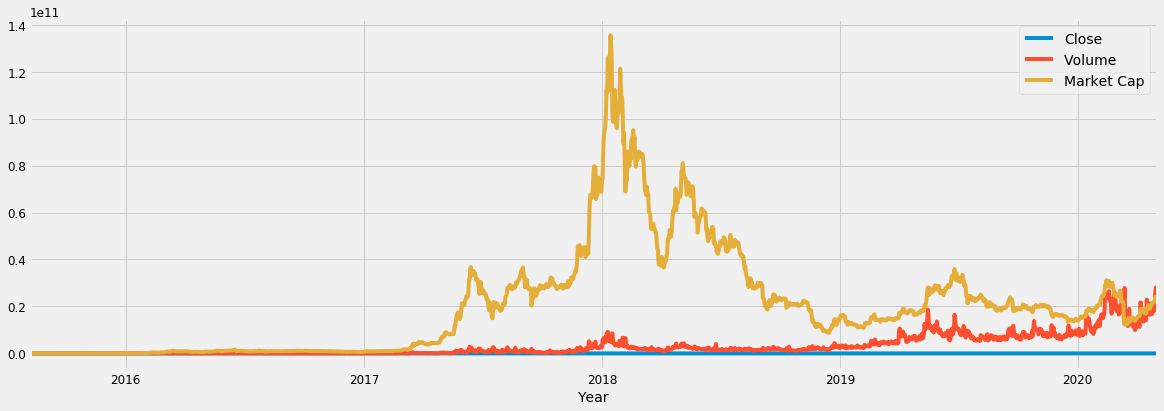

In [53]:
df.plot(figsize=(18,6))
plt.xlabel('Year', fontsize=14);

In [54]:
df.corr()

Close    Volume  Market Cap
Close       1.000000  0.167934    0.996388
Volume      0.167934  1.000000    0.203250
Market Cap  0.996388  0.203250    1.000000

as exected 

In [55]:
cols_one = ['Volume', 'Market Cap']
df_ts = df.drop(cols_one, axis=1, inplace=False)

In [56]:
df_ts.head()

Close
Date                
2015-08-07  2.770000
2015-08-08  0.753325
2015-08-09  0.701897
2015-08-10  0.708448
2015-08-11  1.070000

resampling to monthly price - df named 'y'

In [108]:
y = df_ts['Close'].resample('MS').mean()

visualizing the resampled data

In [109]:
y.plot(figsize=(15, 6))
plt.show()

resampled to weekly data - df - 'x'

In [115]:
x = df_ts['Close'].resample('W').mean()

In [116]:
x.head()

Date
2015-08-09    1.408407
2015-08-16    1.416921
2015-08-23    1.305714
2015-08-30    1.195714
2015-09-06    1.310000
Freq: W-SUN, Name: Close, dtype: float64

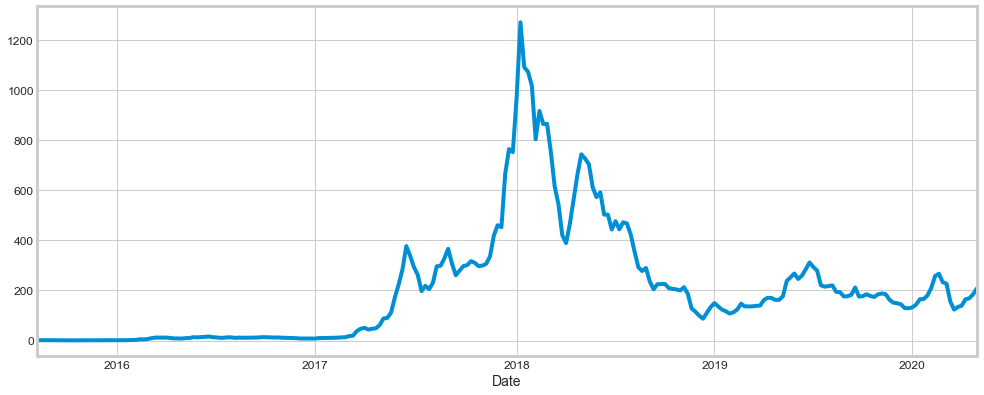

In [117]:
x.plot(figsize=(15, 6))
plt.show()

Test for stationarity 


In [110]:
import seaborn as sns
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller

def dickey_fuller_df(df):
    test = adfuller(df)
    dfoutput = pd.Series(test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput


def rolling_ts_plot(df, halflife, figsize=(15, 10)):
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    mean = df.ewm(halflife=halflife).mean()
    std = df.ewm(halflife=halflife).std()
    df.plot(ax=ax)
    mean.plot(ax=ax)
    std.plot(ax=ax)
    ax.legend(["Original", "Exponentially Weighted Rolling Mean", "Exponentially Weighted Rolling Standard Deviation"]);
    plt.show()


def stationarity_check(df, halflife, figsize=(15, 10)):
    rolling_ts_plot(df, halflife, figsize=figsize)
    return dickey_fuller_df(df)

In [111]:
print(dickey_fuller_df(y))

Test Statistic                 -2.170980
p-value                         0.216946
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


Fail to reject the null - Series is not stationary 

In [112]:
stationarity_check(y,8)

Test Statistic                 -2.170980
p-value                         0.216946
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64

Series is still not stationary 

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise

using non-resampled data - df - df_ts

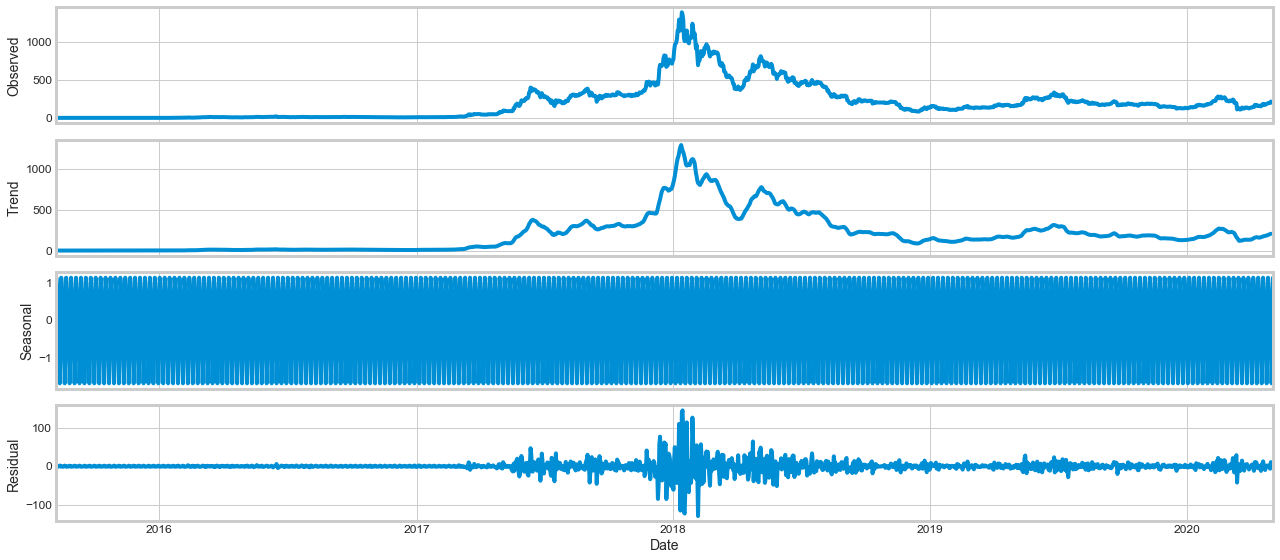

In [113]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_ts, model='additive')
fig = decomposition.plot()
plt.show()

using resample df - 'y'

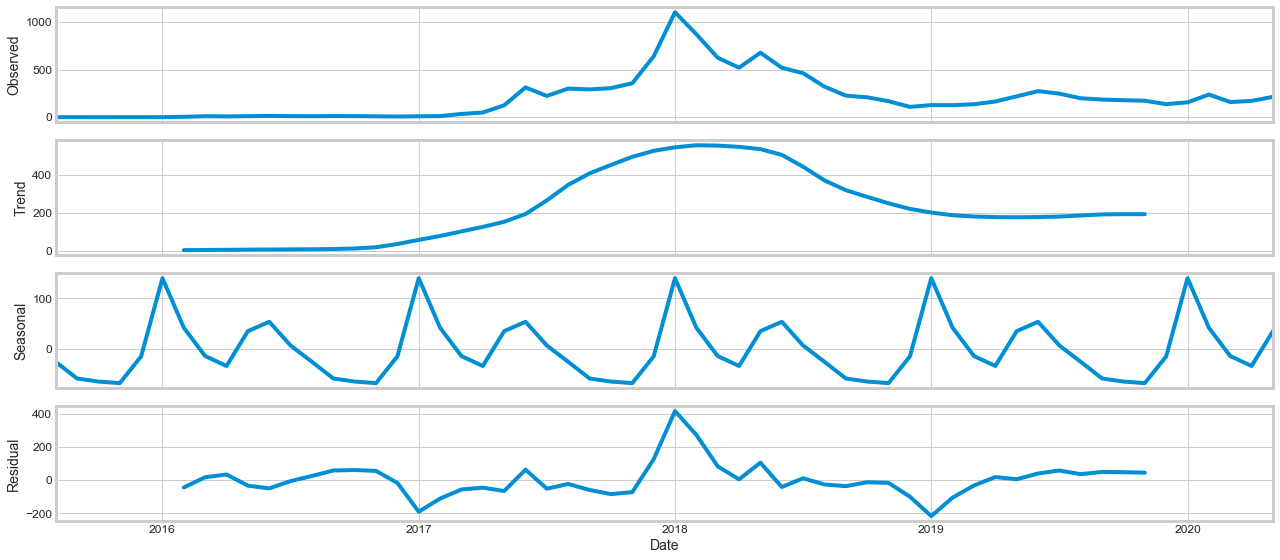

In [114]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()


using resample df - 'x'

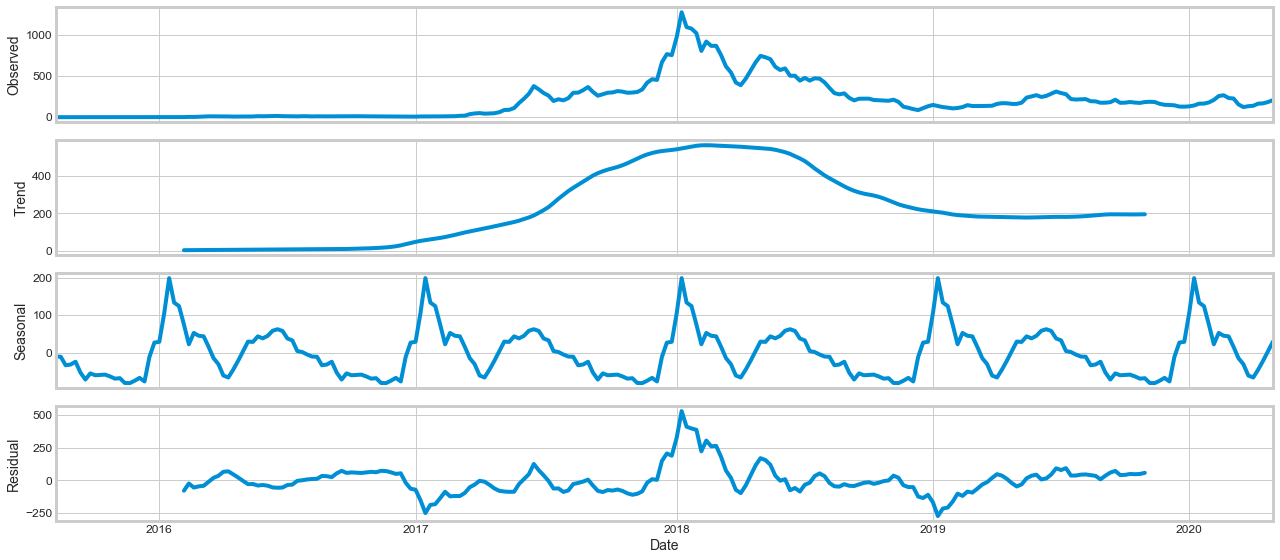

In [118]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(x, model='additive')
fig = decomposition.plot()
plt.show()


Autocorrelation (ACF) - using df 'y'

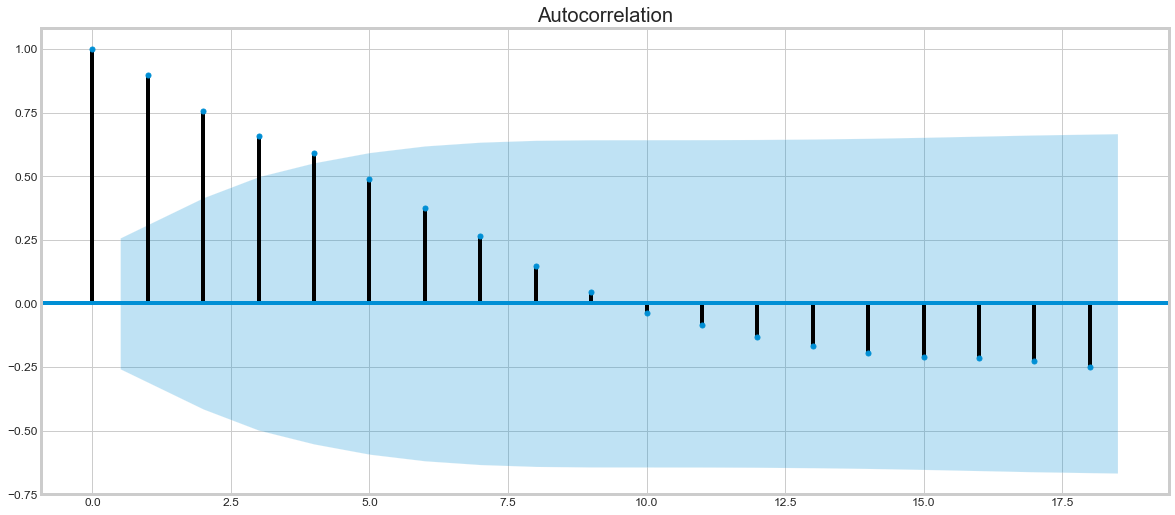

In [127]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y)
pyplot.show()

Partial Autocorrelation (PACF) - using df 'y'

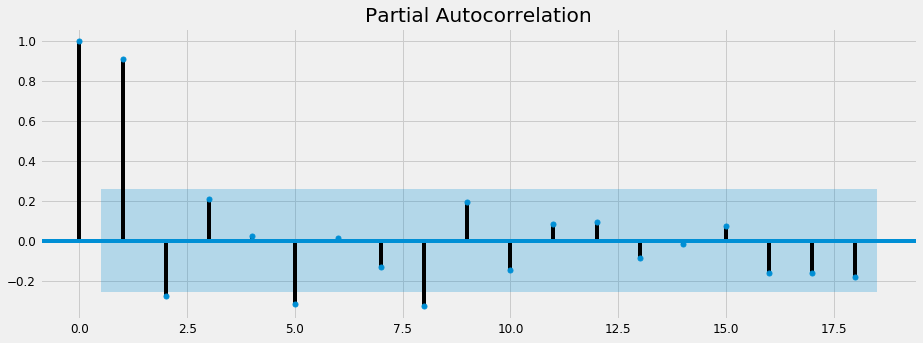

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(y);

ARIMA

In [69]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [89]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:817.0373979953763
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:653.8041074624138
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:663.5545617238911
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1171.9805835811694
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:664.3110673313075
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:649.8076503926033
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:504.58005229523457
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1224.874830505711
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:748.3834208518571
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:599.047806405889
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:611.9307149451183
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1409.1768094061194
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:622.3669253511644
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:597.6510263419808
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:475.2312595512069
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2612.795787603071
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:679.9262254071211
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:547.1555039572478
ARIMA(0,

The above output suggests that SARIMAX(1, 1, 0)x(1, 1, 0, 12) yields the lowest AIC value of 419.53. Therefore we should consider this to be optimal option

Fitting the model

In [90]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1918      0.111      1.730      0.084      -0.026       0.409
ar.S.L12      -0.5652      0.146     -3.865      0.000      -0.852      -0.279
sigma2      2.399e+04   5569.983      4.306      0.000    1.31e+04    3.49e+04


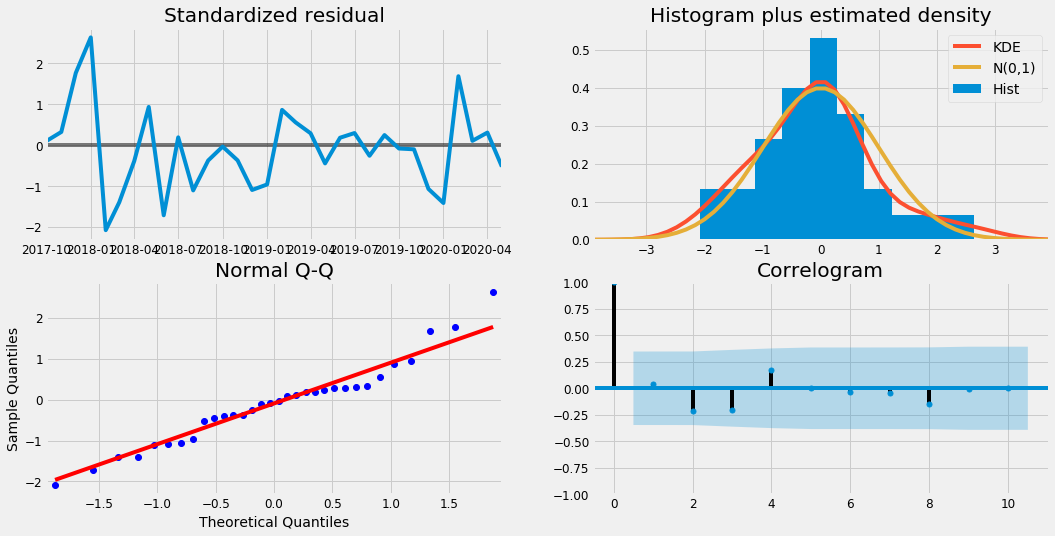

In [91]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Validating forecasts 

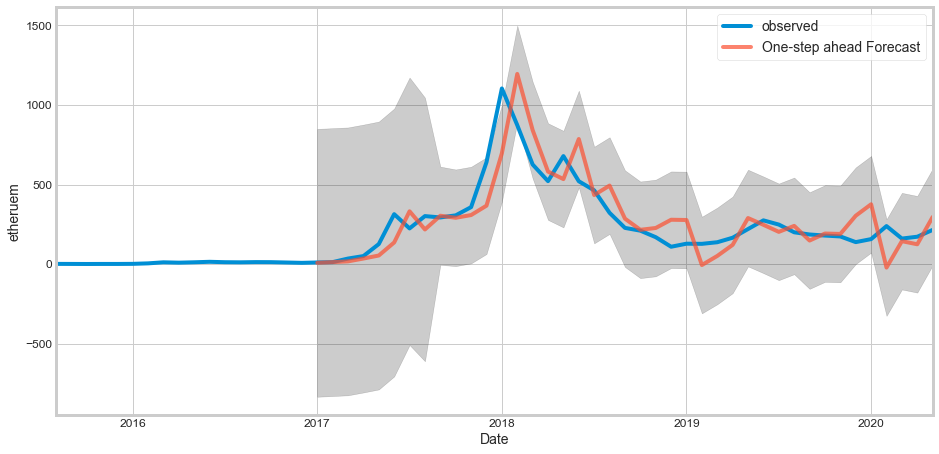

In [121]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('etheruem')
plt.legend()
plt.show()

In [122]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 20090.83


In [123]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 141.74


Producing and visualising forecasts

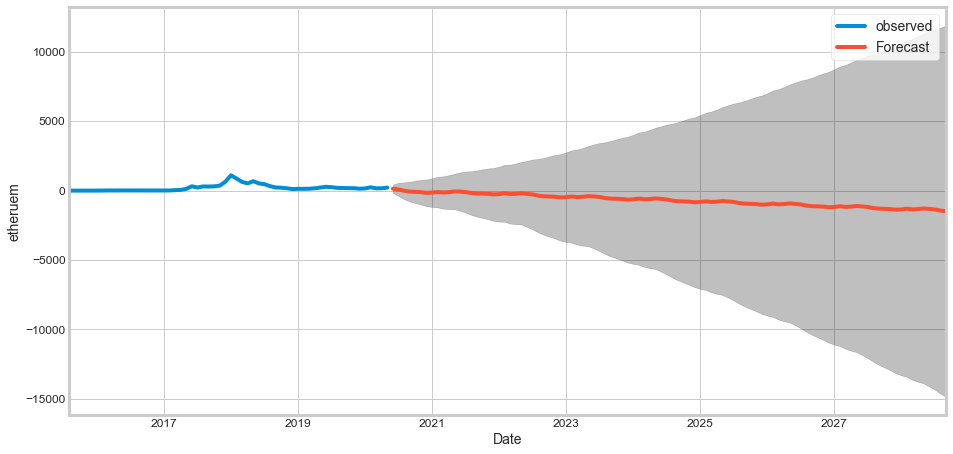

In [125]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('etheruem')
plt.legend()
plt.show()

Using Prophet (thanks to facebook)

In [126]:
from fbprophet import Prophet


ModuleNotFoundError: No module named 'fbprophet'

In [128]:
!pip install fbprophet

     |████████████████████████████████| 61kB 2.9MB/s eta 0:00:01
     |████████████████████████████████| 39.1MB 9.4MB/s eta 0:00:011     |███████████████████████████▋    | 33.8MB 9.4MB/s eta 0:00:01
     |████████████████████████████████| 112kB 8.1MB/s eta 0:00:01
     |████████████████████████████████| 1.5MB 10.9MB/s eta 0:00:01
     |████████████████████████████████| 737kB 8.9MB/s eta 0:00:01
  ERROR: Command errored out with exit status 1:
   command: /Applications/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/lz/j6htzgn57b311_vxtgxhvdfc0000gn/T/pip-install-6wdy2z12/fbprophet/setup.py'"'"'; __file__='"'"'/private/var/folders/lz/j6htzgn57b311_vxtgxhvdfc0000gn/T/pip-install-6wdy2z12/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/lz/j6htzgn57b311_vxtgxhvdfc000

  Created wheel for pymeeus: filename=PyMeeus-0.3.7-cp37-none-any.whl size=702877 sha256=6dd1ca3c1bce6825f32e08c5ede07319aed7669c259b9d4642c85d4c34d01847
  Stored in directory: /Users/rajeevpanwar/Library/Caches/pip/wheels/8d/1a/e7/684cd77a99aac294f976db834fe613b5424f7c4d75ffb0b84d
Successfully built holidays pymeeus
Failed to build fbprophet
  Running setup.py install for fbprophet ... done


In [129]:
!conda install fbprophet

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - fbprophet

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [131]:
!conda config --append channels conda-forge